# A Tool for FDR and Qvalue Estimation in LCMS Data

## imports

First, importing GNPS ion fragments in the form of matchms Spectrum objects.

number of spectra: 112956


Text(0, 0.5, 'number of spectra in respective bin')

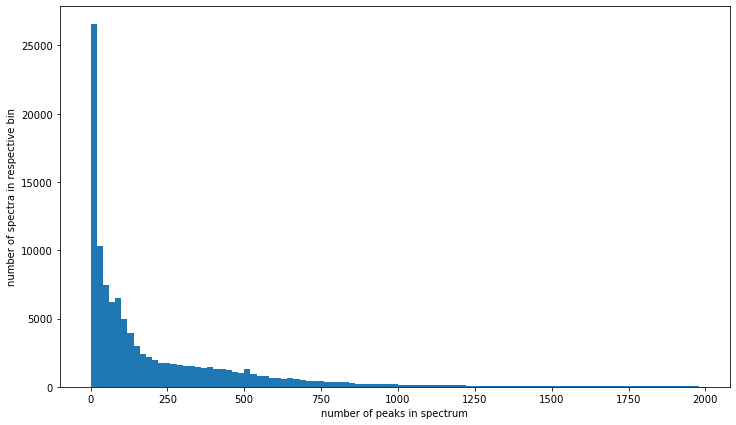

In [1]:
import os
import sys
from random import random
import gensim
import numpy as np
import pandas as pd
import create_spectral_decoys.custom_filtering
from matplotlib import pyplot as plt
from matchms import Scores, Spectrum
from matchms.importing import load_from_json
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses
from matchms.filtering import reduce_to_number_of_peaks
import random
from create_spectral_decoys.decoy_factory import random_sample_5_peaks, get_spectrums_with_peak, return_random_pick
from create_spectral_decoys.custom_fragment import FragmentPeak
from create_spectral_decoys.decoy_factory import DecoyFactory



ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\User\\Data'
sys.path.insert(0, ROOT)

from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Matchms Filters Applied

After import, a number of standard matchms filters are applied to the data. Each Spectrum object is:

- Has intensities normalised
- Has peaks removed that are larger than 1000 Da
- Has peaks removed that are < 0.0001 of maximum intensity
- Has number of peaks reduced to under 100, if this has not yet been achieved by previous filters, removing those with the lowest intensity

In [2]:
def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    s = reduce_to_number_of_peaks(s, 10, 100, None)
    return s


spectrums = [post_process(s) for s in spectrums]
spectrums = [s for s in spectrums if s is not None]


print("Remaining spectra after post process", len(spectrums))

Remaining spectra after post process 69110


## Custom Filters Applied

After these standard matchms filters, a number of custom filters are applied in order to better prepare the data for the decoy creation process:

- All spectrums without a parent peak present in the Spikes object are removed
- All spectrums without a coherent inchi in the metadata are removed
- All spectrums without coherent adduct references in the metadata are removed

In [3]:
from create_spectral_decoys.custom_filtering import are_spectrums_same
from create_spectral_decoys.custom_filtering import return_spectrums_with_parent_peaks, return_spectrums_with_inchi, is_molecule_here, return_spectrums_with_adduct

spectrums = return_spectrums_with_parent_peaks(spectrums)
spectrums = return_spectrums_with_inchi(spectrums)
spectrums = return_spectrums_with_adduct(spectrums)

print("Remaining spectra after post process", len(spectrums))

Remaining spectra after post process 11412


##  Adducts Checked

All spectrum adducts are then checked against a list of adducts understood by the AdductTransformer object, to ensure effective implementation of the noise cancelling tool. All spectrums without a counterpart in the adduct list are removed.

Text(0, 0.5, 'number of spectra in respective bin')

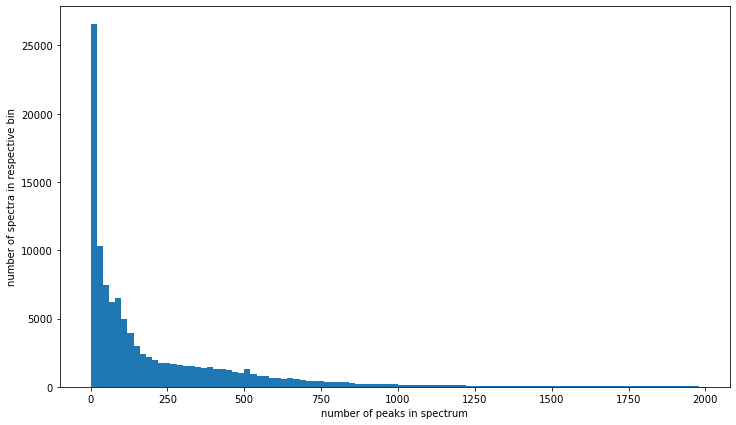

In [4]:
from create_spectral_decoys.custom_filtering import return_spectrums_with_given_adducts

positive_adducts = []

import csv

with open(r'C:\Users\User\Data\positive_adducts.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        row = ', '.join(row)
        positive_adducts.append(row)
        

spectrums = return_spectrums_with_given_adducts(spectrums, positive_adducts)



    

## Fragmentation Data

The data used for the fragmentation tree noise-cancelling is uploaded. 

In [5]:
import glob
import json

json_data = []
a = glob.glob(r'C:\\Users\\User\\Data\\Filtering_Data\\trees\\*.json', recursive=True)

for filename in a:
    with open(filename,'r') as f:
        json_data.append(json.loads(f.read()))

## Unique Chemical Formulas

Here, the chemical formula of each unique fragment is retrieved and added to a list.

Then, that list is de-deduplicated, providing us with a list of chemcial formulas representing all possible molecules in assumed to be in our data set.

In [6]:
print(json_data[1].keys())

chem_formulas = []

for mol in json_data:
    for frag in mol.get('fragments'):
        chem_formulas.append(frag.get('molecularFormula'))
        
print(len(chem_formulas))

unique_chem_formulas = []

for chem in chem_formulas:
    if(chem not in unique_chem_formulas) & (chem != ""):
        unique_chem_formulas.append(chem)
        
print(len(unique_chem_formulas))


dict_keys(['molecularFormula', 'root', 'annotations', 'fragments', 'losses'])
171592
30118


## Adducts in data set

A unique list of all adducts in our spectral dataset is created. A Formula object is instantiated.

In [7]:
adducts = []

for spec in spectrums:
    if(spec.metadata['adduct'] not in adducts):
        adducts.append(spec.metadata['adduct'])
        
from molmass import Formula

print(adducts)

f = Formula(unique_chem_formulas[0])

print("For chem formula ", f.formula, " mass is ", f.mass)




['[M+Na]+', '[M+H]+', '[M+NH4]+', '[M+K]+', '[M+H+Na]2+']
For chem formula  C11H11Br2N5O  mass is  389.04541099999994


## Adduct and Mass Library

An adduct and mass library object is created. The purpose of this object is:

- To take all adducts in the dataset
- To take a list of chemical formulas representing all potential molecules produced by MS experiment
- To create a list for every adduct, where each molecule has been ionised by that adduct
- To filter out all mass peaks present in the spectrum list, where that mass peak does not have a corresponding mass on the appropriate adduct-mass list, unless that mass happens to be the parent peak

Cosine similarity is tested between the pre-noise-filtered and post-noise-filtered spectrum to show that its essential properties have not been destroyed. 


Processed:  4804  chucked:  0
(0.9999999999999993, 99)
(0.959972572796264, 23)


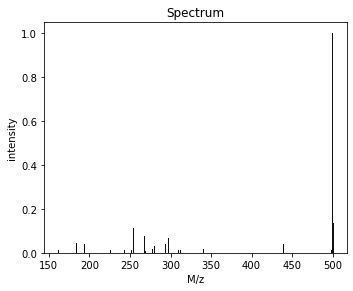

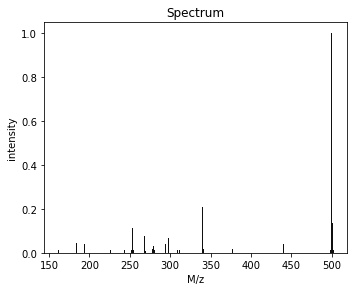

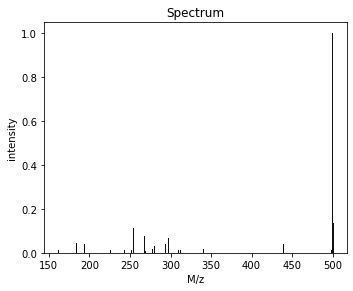

In [8]:
from create_spectral_decoys.noise_filtering import AdductAndMassLibrary
from matchms.similarity import CosineGreedy

AML = AdductAndMassLibrary(adducts, unique_chem_formulas)

noise_filtered_spectrums = []

chucked_spectrums = []


for spec in spectrums:
    spec1 = AML.return_noise_filtered_spectrum(spec)
    if(len(spec1.peaks.mz) == 0):
        chucked_spectrums.append(spec1)
    else:
        noise_filtered_spectrums.append(spec1)

print("Processed: ", len(noise_filtered_spectrums), " chucked: ", len(chucked_spectrums))

cosine_greedy = CosineGreedy(tolerance = 0.2)

print(cosine_greedy(spectrums[1], spectrums[1]))
print(cosine_greedy(spectrums[0], noise_filtered_spectrums[0]))

spectrums[0].plot()
noise_filtered_spectrums[0].plot()

[161.122604 183.110397 193.096497 225.122192 243.103394 251.096802
 251.153107 253.117294 254.131393 267.13031  269.08429  277.124512
 279.091095 280.092804 293.115204 297.104492 308.604401 311.120911
 339.117004 340.11911  377.026703 439.214203 497.4328   499.241486
 500.243896 501.215088]
[161.122604 183.110397 193.096497 225.122192 243.103394 251.096802
 251.153107 253.117294 254.131393 267.13031  269.08429  277.124512
 279.091095 280.092804 293.115204 297.104492 308.604401 311.120911
 340.11911  439.214203 497.4328   499.241486 500.243896]
(0.959972572796264, 23)


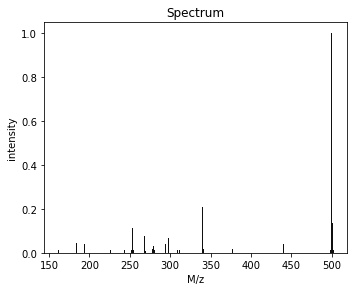

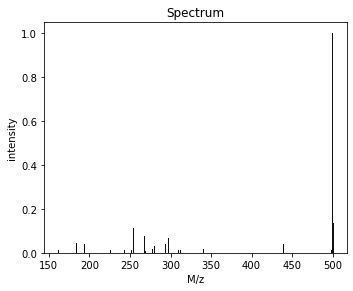

In [9]:
spectrums[0].plot()
noise_filtered_spectrums[0].plot()
print(spectrums[0].peaks.mz)
print(noise_filtered_spectrums[0].peaks.mz)
print(cosine_greedy(spectrums[0], noise_filtered_spectrums[0]))

In [10]:
spectrums = [] 

for spec in noise_filtered_spectrums:
    if(len(spec.peaks.mz) >= 6):
        spectrums.append(spec)

print(len(spectrums))

        

4520


## Creating Query and Target Spectrum Lists

Below, two lists are created:

- A library spectrum list, which will be later used in the decoy creation process
- A query spectrum list, where each molecule present has at least one counterpart in the libary spectrums

Customer filters are used to check for similarity where appropraite

In [11]:
library_spectrums = []
query_spectrums = []

from create_spectral_decoys.custom_filtering import is_molecule_here

for spec in spectrums:
        if(len(library_spectrums) == 2000) & (len(query_spectrums) == 1000):
            break   
        if(is_molecule_here(spec, library_spectrums) == 0) & (len(library_spectrums) < 2000):
            library_spectrums.append(spec)
            
        else:
            if(is_molecule_here(spec,query_spectrums) == 0) & (is_molecule_here(spec, library_spectrums) == 1) & (len(query_spectrums) < 1000):
                query_spectrums.append(spec)
     
          
print("Library spectra: ", len(library_spectrums))
print("Query spectra: ",  len(query_spectrums))


molecule_matches = 0
for spec in query_spectrums:
    if(is_molecule_here(spec, library_spectrums) == 1):
        molecule_matches += 1

print("Molecule matches =", molecule_matches)


Library spectra:  2000
Query spectra:  1000
Molecule matches = 1000


# Decoy Creation

## The Decoy Factory

The decoy factory object takes a list of spectrums and performs a number of functions:

- Transforms every mass peak in the target library list into a FragmentPeak object and stores them in a sorted list.
- Creates decoy spectra using the naive approach.
- Creates decoy spectra using the spectrum-based approach.

## Naive Method

A naive decoy is created in the following manner:

- The precursor peak is taken from the target library and added to the decoy
- Peaks are then randomly selected from the list of fragment peaks and added to the decoy, until the number of peaks in the decoy is equal to the number of peaks in the target

## Spectrum-Based Method

A spectrum-based decoy is crated in the following manner:

- The precursor peak is taken from the target library and added to the decoy
- Then, a list of all spectra in the target library with a mass within 5ppm of that precursor peak is created
- From each spectrum on that list, we uniformly draw 5 fragment ions and add those ions to a list of candidate fragment ions.
- Then we draw a fragment ion from the candidate fragment list and add it to the decoy spectrum if the fragment ion is not already present in the decoy spectrum (within mass tolerance of 5 p.p.m) and the fragment ion’s mass is less than the mass of the precursor peak
- We then repeat this process using the mass of the most recently added fragment ion, until the number of peaks in the decoy is equal to the number of peaks in the target. 




In [12]:
# from decoy_factory import DecoyFactory

# df = DecoyFactory(library_spectrums)
# df.strip_fragments()
# df.create_naive_decoys_list()
# df.create_spectrum_based_decoy_list()

# library_spectrums = df.target_spectrums
# complex_decoy_spectrums = df.sb_decoys
# naive_decoy_spectrums = df.n_decoys 

In [13]:
# np.save('target_spectrums_final', df.target_spectrums)
# np.save('Complex_decoys_final', df.sb_decoys)
# np.save('Naive_decoys_final', df.n_decoys)
# np.save('query_spectrums_final', query_spectrums)

In [14]:
library_spectrums = np.load(r'C:\Users\User\Data\used_decoys\final\target_spectrums_final.npy', allow_pickle = True)
complex_decoy_spectrums = np.load(r'C:\Users\User\Data\used_decoys\final\Complex_decoys_final.npy', allow_pickle = True)
naive_decoy_spectrums = np.load(r'C:\Users\User\Data\used_decoys\final\Naive_decoys_final.npy',  allow_pickle = True)
query_spectrums= np.load(r'C:\Users\User\Data\used_decoys\final\query_spectrums_final.npy',  allow_pickle = True)

## Cosine Similarity Scoring

Three scoring processed are now undergone:

- The query spectra are scored against the target library
- The query spectra are scored against the naive-decoy library
- The query spectra are scored against the spectrum-based decoy library

The resultant hits are stored as custom CosineHit objects

In [16]:
from custom_analysis import return_list_cosine_scores

scores_library = return_list_cosine_scores(query_spectrums, library_spectrums, "library")

print(len(scores_library))

for score in scores_library[-20:]:
    print(score.score)

scores_library_sorted = sorted(scores_library)

for score in scores_library_sorted[-20:]:
    print(score.score)

1000
0.9461780460413303
0.011187765414038557
0.08127042346026989
0.19664178364476567
0.10371154478755386
0.3779809609780372
0.8686197856818669
0.9886546837959607
0.28632864891828913
0.5265072394774969
0.5430546741432818
0.42672347848578257
0.6364435201184537
0.3052693958108882
0.6145403178905645
0.951511639423067
0.3631023492103997
0.25240768189521934
0.4075397600731274
0.018903142527605478
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000009


In [17]:

scores_complex = return_list_cosine_scores(query_spectrums, complex_decoy_spectrums, "decoy")

scores_naive= return_list_cosine_scores(query_spectrums, naive_decoy_spectrums, "decoy")

print(len(scores_complex))

for score in scores_complex[-20:]:
    print(score.score)

scores_complex_decoys_sorted = sorted(scores_complex)
scores_naive_decoys_sorted = sorted(scores_naive)

for score in scores_complex_decoys_sorted[-20:]:
    print(score.score)


1000
0.9149254836509456
0.9598372086034331
0.9598372086034331
0.5839697663911253
0.20310203928295764
0.22057982805703938
0.5701854258022342
0.8970039680826092
0.514308347578496
0.5217882501233826
0.5441113363060481
0.34280323083243686
0.6463133642130844
0.12832204475973275
0.47614809000249236
0.5823562251803428
0.6769392378036082
0.6370443800357345
0.409936069781379
0.2789293920997097
0.9563698770743856
0.9569535424166334
0.9578706151960125
0.9580206263017972
0.9591762139341882
0.9591762139341882
0.9591998279785706
0.9596849017081178
0.9598372086034331
0.9598372086034331
0.9632700475198276
0.9677082718190777
0.9683766107240556
0.9684022673830631
0.9709621380591524
0.9736115944797029
0.9762356964681259
0.9775235609425654
0.9815563991026189
0.9921513946981231


In [18]:
np.save("scores_complex_decoys_final", scores_complex_decoys_sorted)
np.save("scores_naive_decoys_final", scores_naive_decoys_sorted)
np.save("scores_library_final", scores_library_sorted)

In [19]:
# scores_complex = np.load(r"C:\Users\User\Data\scores\NF\NF_scores_complex_decoys.npy", allow_pickle = True).tolist()
# scores_naive = np.load(r"C:\Users\User\Data\scores\NF\NF_scores_naive_decoys.npy", allow_pickle = True).tolist()
# scores_library= np.load(r"C:\Users\User\Data\scores\NF\NF_scores_library.npy", allow_pickle = True).tolist()

## FDR and Q value Analysis

In the case of the target decoy approaches, two DecoyAnalysis objects are created. These objects:

- Take a merged list of decoy and library hits
- Peform False Discovery Rate estimation for each library hit
- Perform qvalue estimation for each library hit

A TrueAnalysis object:

- Takes a list of hits against a target library
- Calculates the true False Discovery Rate
- Assigns a qvalue to each hit

In [21]:
scores_complex_merged = sorted (scores_library + scores_complex)
scores_naive_merged = sorted(scores_library + scores_naive)
scores_library_sorted = sorted(scores_library)

from create_spectral_decoys.decoy_analysis import DecoyAnalysis

sb_analysis = DecoyAnalysis(scores_complex_merged, 0.25, "spectrum-based")
n_analysis = DecoyAnalysis(scores_naive_merged, 0.25, "naive")

sb_analysis.create_fdr_list()
sb_analysis.create_q_values()
n_analysis.create_fdr_list()
n_analysis.create_q_values()




PIT is  0.25
1000 FDRs created
1000  qvalues created
PIT is  0.25
1000 FDRs created
1000  qvalues created


In [23]:
from create_spectral_decoys.true_q_analysis import TrueAnalysis

t_analysis = TrueAnalysis(scores_library_sorted, 0, "trues")
t_analysis.create_fdr_list()
t_analysis.create_q_values()


1000  fdrs created
1000  qvalues created


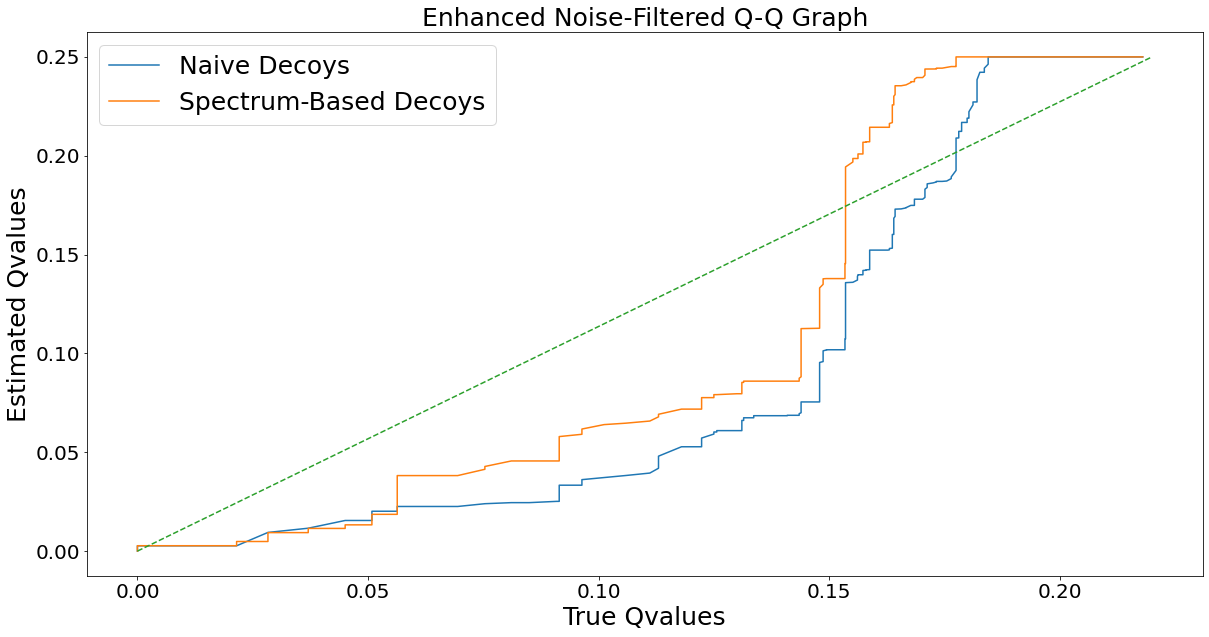

In [24]:
plt.figure(figsize=(20,10))
plt.title("Enhanced Noise-Filtered Q-Q Graph", fontsize=25)
plt.xlabel( 'True Qvalues', fontsize=25)
plt.ylabel('Estimated Qvalues', fontsize=25)
plt.plot(t_analysis.qvalues, n_analysis.qvalues, label = "Naive Decoys")
plt.plot(t_analysis.qvalues, sb_analysis.qvalues, label = "Spectrum-Based Decoys")
plt.plot(np.linspace(0,0.22),np.linspace(0,0.25), ls='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)
fig1 = plt.gcf()

In [ ]:
fig1.savefig('Enhanced Noise-Filtered Q-Q Graph_20SEPT.png')

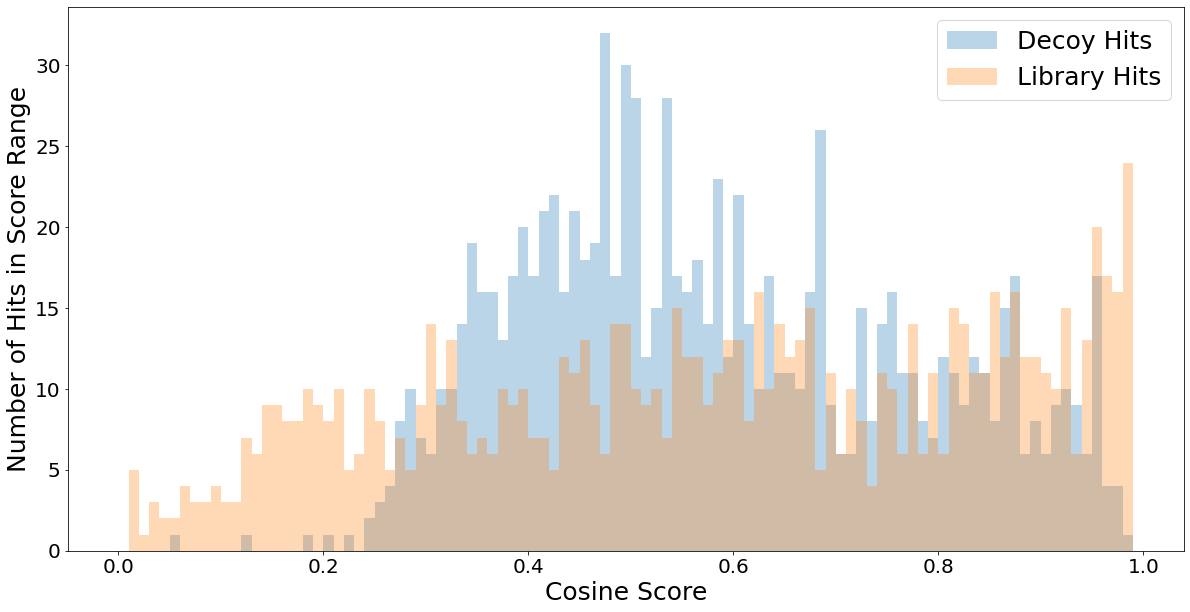

In [25]:


bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(20,10))
plt.hist(sb_analysis.decoyscores, bins, alpha = 0.3, label='Decoy Hits')
plt.hist(sb_analysis.libscores, bins, alpha = 0.3, label='Library Hits')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel( 'Cosine Score', fontsize=25)
plt.ylabel('Number of Hits in Score Range', fontsize=25)
plt.legend(loc='upper right')
plt.legend(fontsize=25)
fig1 = plt.gcf()

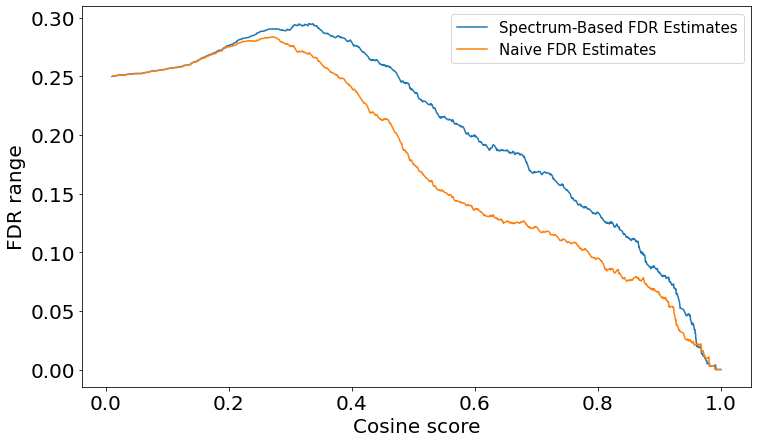

In [26]:
plt.figure(figsize=(12,7))
plt.plot(sb_analysis.libscores, sb_analysis.fdrlist, label = "Spectrum-Based FDR Estimates")
plt.plot(n_analysis.libscores, n_analysis.fdrlist, label = "Naive FDR Estimates")
plt.xlabel("Cosine score",  fontsize=20)
plt.ylabel("FDR range", fontsize=20)
plt.legend(fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig1 = plt.gcf()


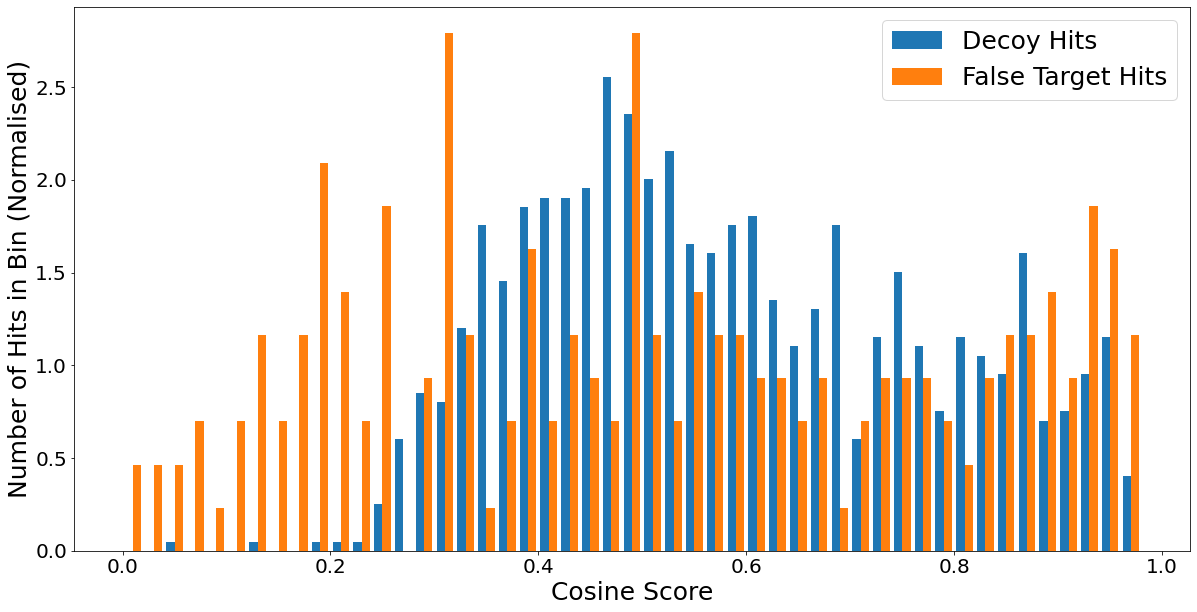

In [42]:
import random

target_false_hits = t_analysis.falsescores
len(target_false_hits)

bins = np.arange(0, 1, 0.02)
plt.figure(figsize=(20,10))
plt.hist([sb_analysis.decoyscores, t_analysis.falsescores], bins, label=['Decoy Hits', 'False Target Hits'], density = True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel( 'Cosine Score', fontsize=25)
plt.ylabel('Number of Hits in Bin (Normalised)', fontsize=25)
plt.legend(loc='upper right')
plt.legend(fontsize=25)
fig1 = plt.gcf()